In [1]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tabulate import tabulate
from statistics import mean

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from skmultilearn.model_selection import IterativeStratification

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

# 1) Experimentando Diferentes conjuntos de dados

## 1.1) Pré-processamento

### 1.1.1) Flatten train 

In [2]:
def config_flatten_train(y_train, y_test): 
    y_train_flatten = y_train.values.ravel()
    y_test_flatten = y_test.values.ravel()

    return y_train_flatten, y_test_flatten

### 1.1.2) Configurando LabelEncoder

In [3]:
def config_label_encoder(y_train, y_test):
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    return y_train_encoded, y_test_encoded

### 1.1.3) Padronizar as características (normalização)

In [4]:
def config_start_scaler(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

### 1.1.4) Pré-processando dados

In [5]:
def config_one_hot(y_train_encoded, y_test_encoded):
    num_classes = len(np.unique(y_train_encoded))

    # Converta as classes em vetores one-hot (para a camada de saída)
    y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
    y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)

    return y_train_onehot, y_test_onehot

## 1.2) Carregar os dados de treinamento e teste

In [6]:
X_train_array = []
y_train_array = []
X_test_array = []
y_test_array = []  

def get_data_from_conjunto(conjunto: int):      

    X_train = pd.read_csv(f'../Dados/RedesNeurais/Conjunto_{conjunto+1}/X_train.csv')
    y_train = pd.read_csv(f'../Dados/RedesNeurais/Conjunto_{conjunto+1}/y_train.csv')
    X_test = pd.read_csv(f'../Dados/RedesNeurais/Conjunto_{conjunto+1}/X_test.csv')
    y_test = pd.read_csv(f'../Dados/RedesNeurais/Conjunto_{conjunto+1}/y_test.csv')

    num_classes = len(np.unique(y_train))
    input = X_train.shape[1]
    
    y_train, y_test = config_flatten_train(y_train, y_test)
    y_train, y_test = config_label_encoder(y_train, y_test)
    # y_train, y_test = config_start_scaler(X_train, X_test)
    y_train, y_test = config_one_hot(y_train, y_test)

    X_train_array.append(X_train)
    y_train_array.append(y_train)
    X_test_array.append(X_test)
    y_test_array.append(y_test)

    return num_classes, input, X_train_array, y_train_array, X_test_array, y_test_array

## 1.3) Montando rede

In [7]:
def build_neural_network(num_classes, input):

    neuralNetwork = Sequential()
    neuralNetwork.add(Dense(64, input_dim=input, activation='relu'))
    neuralNetwork.add(Dense(32, activation='relu'))
    neuralNetwork.add(Dense(num_classes, activation='softmax'))  

    # neuralNetwork.summary()

    return neuralNetwork

## 1.4) Treinando modelo

In [8]:
def kfold_cross_validation(X_train, y_train, num_classes, input_dim):

    
    kfold = IterativeStratification(n_splits=5)

    acuracias = []
    precisoes = []
    revocacoes = []
    f1_scores = []

    i = 1

    best_acuracia = 0.0
    best_model = None

    for train_index, test_index in kfold.split(X_train, y_train):
        print(f'\nFold {i}')

        X_treino_fold, X_teste_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_treino_fold, y_teste_fold = y_train[train_index], y_train[test_index]

        X_treino_fold = X_treino_fold.astype('float32')
        y_treino_fold = y_treino_fold.astype('float32')
        X_teste_fold = X_teste_fold.astype('float32')

        neuralNetwork = build_neural_network(num_classes, input_dim)
        neuralNetwork.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        neuralNetwork.fit(X_treino_fold, y_treino_fold, epochs=100, batch_size=32, verbose=0)

        y_pred = neuralNetwork.predict(X_teste_fold)

        y_pred_labels = np.argmax(y_pred, axis=1)
        y_teste_labels = np.argmax(y_teste_fold, axis=1)

        acuracia = accuracy_score(y_teste_labels, y_pred_labels)
        precisao = precision_score(y_teste_labels, y_pred_labels, average='weighted')
        revocacao = recall_score(y_teste_labels, y_pred_labels, average='weighted')
        f1 = f1_score(y_teste_labels, y_pred_labels, average='weighted')

        acuracias.append(acuracia)
        precisoes.append(precisao)
        revocacoes.append(revocacao)
        f1_scores.append(f1)

        # Check if the current model has the best F1-score
        if acuracia > best_acuracia:
            best_acuracia = acuracia
            best_model = neuralNetwork

        i = i + 1

    # Calculate mean and standard deviation
    media_acuracias = np.mean(acuracias)
    media_precisoes = np.mean(precisoes)
    media_revocacoes = np.mean(revocacoes)
    media_f1_scores = np.mean(f1_scores)

    desvio_padrao_acuracias = np.std(acuracias)
    desvio_padrao_precisoes = np.std(precisoes)
    desvio_padrao_revocacoes = np.std(revocacoes)
    desvio_padrao_f1_scores = np.std(f1_scores)

    # Display results
    print('\n---')
    for j in range(len(acuracias)):
        print(f'Fold {j + 1}:')
        print(f'Acurácia: {acuracias[j]}')
        print(f'Precisão: {precisoes[j]}')
        print(f'Revocação: {revocacoes[j]}')
        print(f'F1-Score: {f1_scores[j]}')
        print('---')

    print('\nMédias e Desvios Padrão Gerais:')
    print("----------------------------------------------------------------")
    print(f'Média Acurácias: {media_acuracias}')
    print(f'Desvio Padrão Acurácias: {desvio_padrao_acuracias}\n')
    print(f'Média Precisões: {media_precisoes}')
    print(f'Desvio Padrão Precisões: {desvio_padrao_precisoes}\n')
    print(f'Média Revocações: {media_revocacoes}')
    print(f'Desvio Padrão Revocações: {desvio_padrao_revocacoes}\n')
    print(f'Média F1-Scores: {media_f1_scores}')
    print(f'Desvio Padrão F1-Scores: {desvio_padrao_f1_scores}\n')

    return media_acuracias, media_precisoes, media_revocacoes, media_f1_scores, best_model

## 1.5) Carregando dados e treinando (Cross validation)

In [9]:
conjuntos = 10
resultados_acuracia = []
resultados_precisao = []
resultados_revocacao = []
resultados_f1 = []
best_models = []

for i in range(conjuntos):
    print(f'\nConjunto {i + 1}')
    num_classes, input, X_train_array, y_train_array, X_test_array, y_test_array = get_data_from_conjunto(i)

    media_acuracia, media_precisao, media_revocacao, media_f1, best_model = kfold_cross_validation(X_train_array[i], y_train_array[i], num_classes, input)

    resultados_acuracia.append(media_acuracia)
    resultados_precisao.append(media_precisao)
    resultados_revocacao.append(media_revocacao)
    resultados_f1.append(media_f1)
    best_models.append(best_model)


Conjunto 1

Fold 1


5/5 [==============================] - 0s 999us/step

Fold 2
5/5 [==============================] - 0s 1000us/step

Fold 3
5/5 [==============================] - 0s 750us/step

Fold 4
5/5 [==============================] - 0s 1000us/step

Fold 5
5/5 [==============================] - 0s 750us/step

---
Fold 1:
Acurácia: 0.9496402877697842
Precisão: 0.9511153540510701
Revocação: 0.9496402877697842
F1-Score: 0.9489321694009557
---
Fold 2:
Acurácia: 0.9290780141843972
Precisão: 0.9296647618614936
Revocação: 0.9290780141843972
F1-Score: 0.9285935743905747
---
Fold 3:
Acurácia: 0.9290780141843972
Precisão: 0.9310621411685241
Revocação: 0.9290780141843972
F1-Score: 0.9293863706444649
---
Fold 4:
Acurácia: 0.9142857142857143
Precisão: 0.9206051091765378
Revocação: 0.9142857142857143
F1-Score: 0.9116790704551615
---
Fold 5:
Acurácia: 0.935251798561151
Precisão: 0.9390263530415559
Revocação: 0.935251798561151
F1-Score: 0.9357455894883587
---

Médias e Desvios Padrão Gerais:
--------------------

In [10]:
# Criar um DataFrame com os resultados
resultados_acuracia_percent = [f"{acuracia * 100:.2f}%" for acuracia in resultados_acuracia]
resultados_precisao_percent = [f"{precisao * 100:.2f}%" for precisao in resultados_precisao]
resultados_revocacao_percent = [f"{revocacao * 100:.2f}%" for revocacao in resultados_revocacao]
resultados_f1_percent = [f"{f1 * 100:.2f}%" for f1 in resultados_f1]

# Criar um DataFrame com os resultados
data = {
    'Conjunto': [f'Conjunto {i+1}' for i in range(conjuntos)],
    'Acurácia': resultados_acuracia_percent,
    'Precisão': resultados_precisao_percent,
    'Revocação': resultados_revocacao_percent,
    'F1': resultados_f1_percent
}

df_resultados = pd.DataFrame(data)

print("# Resultados Médios do treinamento em 10 Conjuntos de Dados\n")
print(df_resultados.to_markdown(index=False))

# Resultados Médios do treinamento em 10 Conjuntos de Dados

| Conjunto    | Acurácia   | Precisão   | Revocação   | F1     |
|:------------|:-----------|:-----------|:------------|:-------|
| Conjunto 1  | 93.15%     | 93.43%     | 93.15%      | 93.09% |
| Conjunto 2  | 94.43%     | 94.56%     | 94.43%      | 94.38% |
| Conjunto 3  | 91.71%     | 91.89%     | 91.71%      | 91.58% |
| Conjunto 4  | 91.42%     | 91.91%     | 91.42%      | 91.37% |
| Conjunto 5  | 95.43%     | 95.45%     | 95.43%      | 95.41% |
| Conjunto 6  | 93.86%     | 94.04%     | 93.86%      | 93.80% |
| Conjunto 7  | 92.71%     | 93.12%     | 92.71%      | 92.63% |
| Conjunto 8  | 94.01%     | 94.10%     | 94.01%      | 93.96% |
| Conjunto 9  | 95.00%     | 95.26%     | 95.00%      | 95.01% |
| Conjunto 10 | 94.72%     | 94.82%     | 94.72%      | 94.69% |


## 1.6) Analisando resultados gerais

In [11]:
# Calculate the overall mean
overall_mean_acuracia = sum(resultados_acuracia) / len(resultados_acuracia)
overall_mean_precisao = sum(resultados_precisao) / len(resultados_precisao)
overall_mean_revocacao = sum(resultados_revocacao) / len(resultados_revocacao)
overall_mean_f1 = sum(resultados_f1) / len(resultados_f1)

# Create a DataFrame
data = {
    'Acurácia': [overall_mean_acuracia],
    'Precisão': [overall_mean_precisao],
    'Revocação': [overall_mean_revocacao],
    'F1-Score': [overall_mean_f1]
}

df = pd.DataFrame(data)

# Display the table
print(df)

   Acurácia  Precisão  Revocação  F1-Score
0  0.936441  0.938573   0.936441  0.935923


## 1.7) Predição, Matriz de confusão e Métricas de eficácia

----------------------------------------------------------------
Eficácia do conjunto 1
10/10 [==============================] - 0s 667us/step


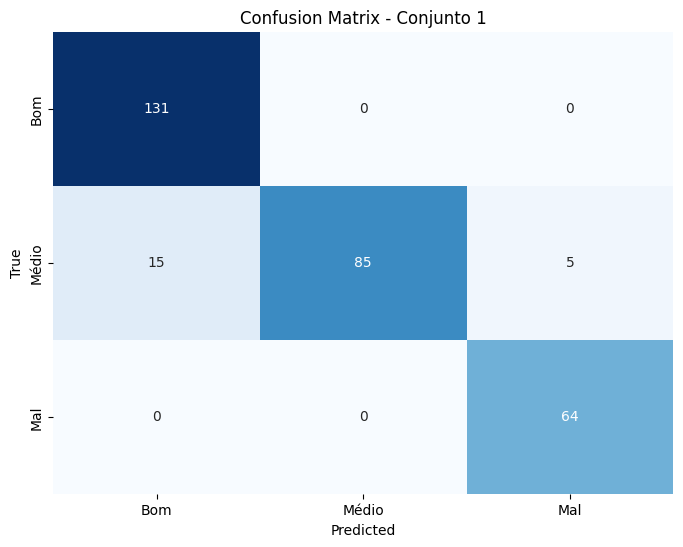

Acurácia no conjunto de teste: 93.33%

Precisão no conjunto de teste: 93.97%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       131
           1       1.00      0.81      0.89       105
           2       0.93      1.00      0.96        64

    accuracy                           0.93       300
   macro avg       0.94      0.94      0.93       300
weighted avg       0.94      0.93      0.93       300


----------------------------------------------------------------

Eficácia do conjunto 2
10/10 [==============================] - 0s 778us/step


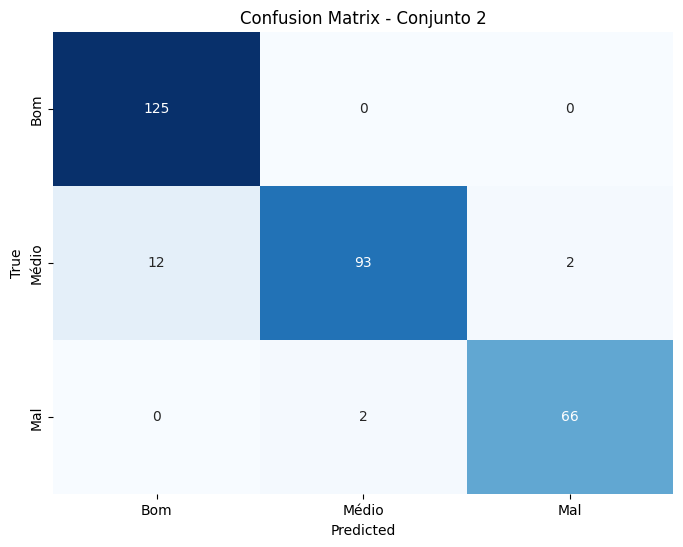

Acurácia no conjunto de teste: 94.67%

Precisão no conjunto de teste: 94.93%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       125
           1       0.98      0.87      0.92       107
           2       0.97      0.97      0.97        68

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300


----------------------------------------------------------------

Eficácia do conjunto 3
10/10 [==============================] - 0s 889us/step


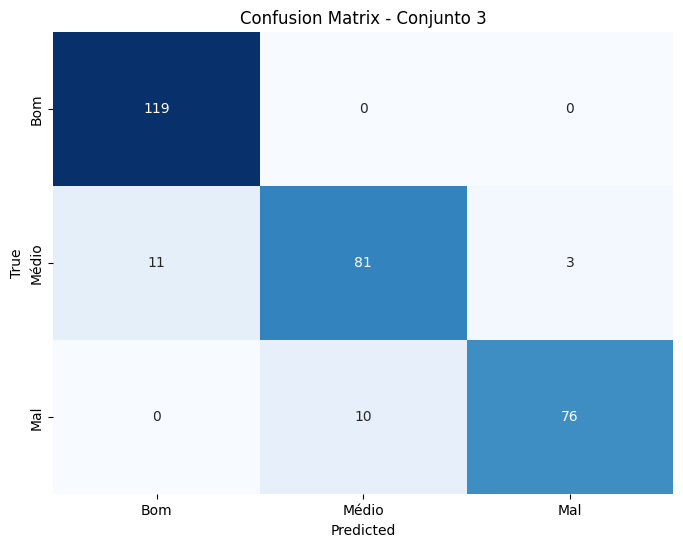

Acurácia no conjunto de teste: 92.00%

Precisão no conjunto de teste: 92.08%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       119
           1       0.89      0.85      0.87        95
           2       0.96      0.88      0.92        86

    accuracy                           0.92       300
   macro avg       0.92      0.91      0.92       300
weighted avg       0.92      0.92      0.92       300


----------------------------------------------------------------

Eficácia do conjunto 4
10/10 [==============================] - 0s 778us/step


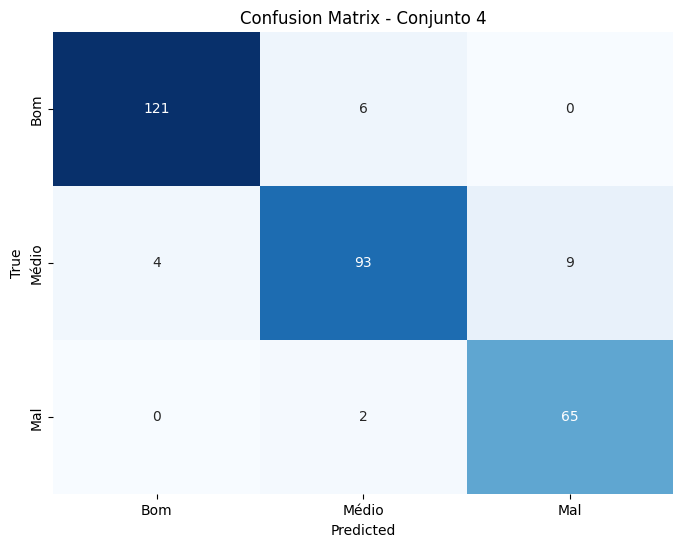

Acurácia no conjunto de teste: 93.00%

Precisão no conjunto de teste: 93.13%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       127
           1       0.92      0.88      0.90       106
           2       0.88      0.97      0.92        67

    accuracy                           0.93       300
   macro avg       0.92      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300


----------------------------------------------------------------

Eficácia do conjunto 5
10/10 [==============================] - 0s 917us/step


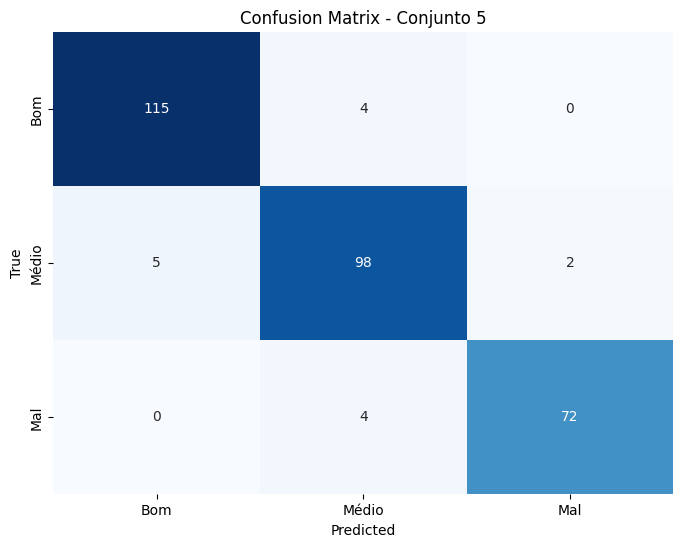

Acurácia no conjunto de teste: 95.00%

Precisão no conjunto de teste: 95.02%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       119
           1       0.92      0.93      0.93       105
           2       0.97      0.95      0.96        76

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300


----------------------------------------------------------------

Eficácia do conjunto 6
10/10 [==============================] - 0s 785us/step


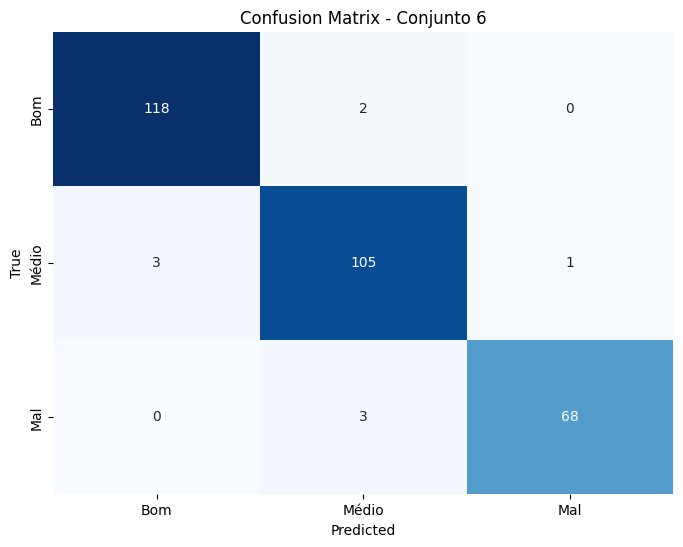

Acurácia no conjunto de teste: 97.00%

Precisão no conjunto de teste: 97.01%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       120
           1       0.95      0.96      0.96       109
           2       0.99      0.96      0.97        71

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300


----------------------------------------------------------------

Eficácia do conjunto 7
10/10 [==============================] - 0s 670us/step


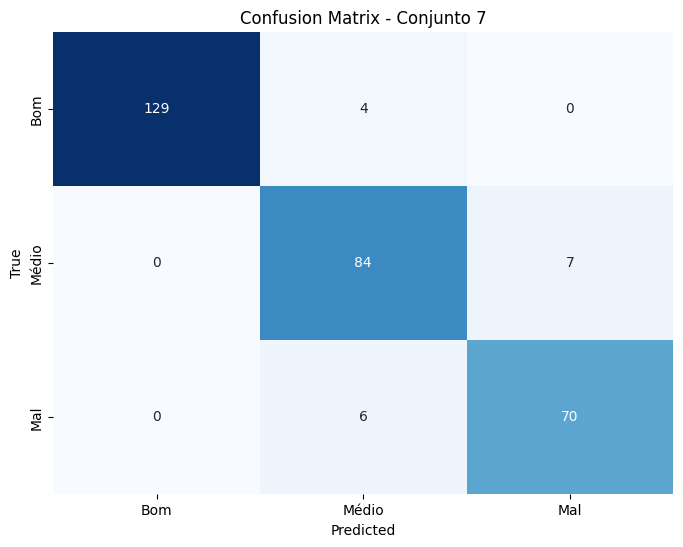

Acurácia no conjunto de teste: 94.33%

Precisão no conjunto de teste: 94.47%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       133
           1       0.89      0.92      0.91        91
           2       0.91      0.92      0.92        76

    accuracy                           0.94       300
   macro avg       0.93      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300


----------------------------------------------------------------

Eficácia do conjunto 8
10/10 [==============================] - 0s 778us/step


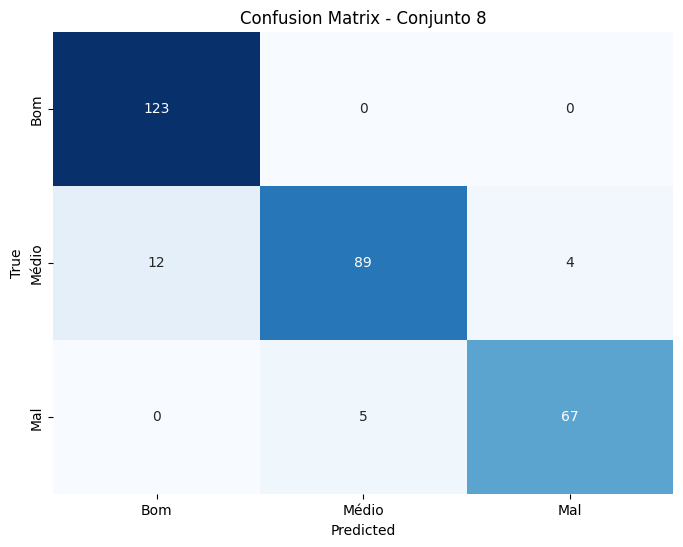

Acurácia no conjunto de teste: 93.00%

Precisão no conjunto de teste: 93.14%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       123
           1       0.95      0.85      0.89       105
           2       0.94      0.93      0.94        72

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300


----------------------------------------------------------------

Eficácia do conjunto 9
10/10 [==============================] - 0s 778us/step


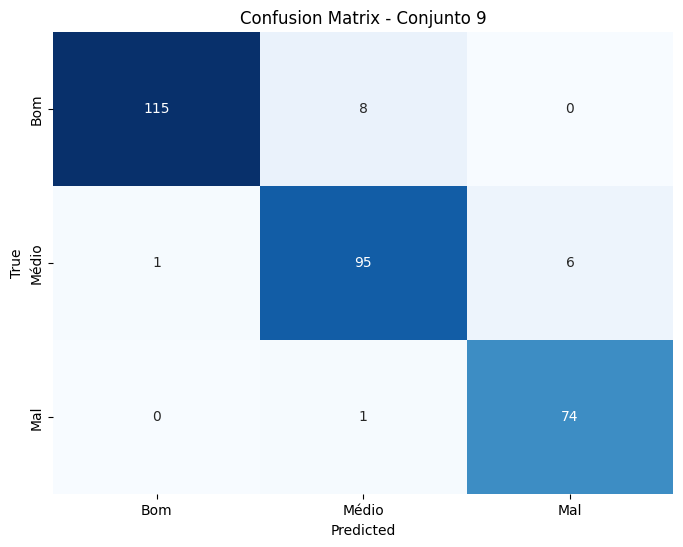

Acurácia no conjunto de teste: 94.67%

Precisão no conjunto de teste: 94.83%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       123
           1       0.91      0.93      0.92       102
           2       0.93      0.99      0.95        75

    accuracy                           0.95       300
   macro avg       0.94      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300


----------------------------------------------------------------

Eficácia do conjunto 10
10/10 [==============================] - 0s 778us/step


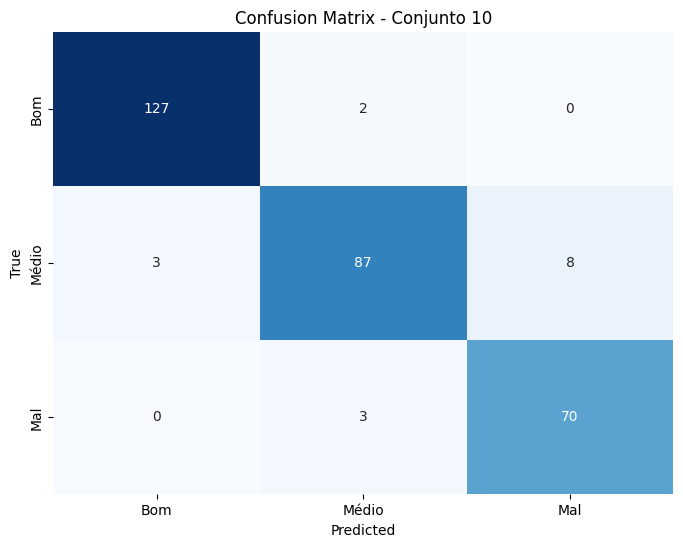

Acurácia no conjunto de teste: 94.67%

Precisão no conjunto de teste: 94.74%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       129
           1       0.95      0.89      0.92        98
           2       0.90      0.96      0.93        73

    accuracy                           0.95       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.95      0.95      0.95       300


----------------------------------------------------------------



In [13]:
print("----------------------------------------------------------------")
# List to store average accuracies for each conjunto
average_accuracies = []
average_precisions = []
for i in range(conjuntos):
    print(f'Eficácia do conjunto {i + 1}')
    X_test = X_test_array[i]
    y_test = y_test_array[i]

    # Load the trained model for the current dataset
    neuralNetwork = best_models[i]

    # Ensure that the data type is float32
    X_test = X_test.astype('float32')

    # Make predictions on the test set
    y_pred = neuralNetwork.predict(X_test)

    # Convert predictions to labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Bom', 'Médio', 'Mal'], yticklabels=['Bom', 'Médio', 'Mal'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - Conjunto {i + 1}')
    plt.show()

    # Calculate and print accuracy
    accuracy = accuracy_score(y_test_labels, y_pred_labels)

    # Append accuracy to the list
    average_accuracies.append(accuracy)
    
    print(f'Acurácia no conjunto de teste: {accuracy * 100:.2f}%\n')

    precision = precision_score(y_test_labels, y_pred_labels, average='weighted')

    # Append accuracy to the list
    average_precisions.append(precision)

    print(f'Precisão no conjunto de teste: {precision * 100:.2f}%\n')


    # Print classification report
    classification_rep = classification_report(y_test_labels, y_pred_labels)
    print(f'Relatório de Classificação:\n{classification_rep}')
    

    print('\n----------------------------------------------------------------\n')

## 1.8) Verificando o conjunto que obteve os melhores resultados

In [14]:
# Find the index of the conjunto with the highest average accuracy
accuracy_mean = mean(average_accuracies)
precision_mean = mean(average_precisions)

best_conjunto_index = np.argmax(average_accuracies)

# Acuracia media de todos os conjuntos
print(f'Acurácia média de todos os conjuntos: {accuracy_mean * 100:.2f}%')

# Precisao media de todos os conjuntos
print(f'Precisão média de todos os conjuntos: {precision_mean * 100:.2f}%')

# Print the conjunto with the highest average accuracy
print(f"\nO conjunto {best_conjunto_index + 1} obteve os melhores resultados.")

Acurácia média de todos os conjuntos: 94.17%
Precisão média de todos os conjuntos: 94.33%

O conjunto 6 obteve os melhores resultados.


# 2) Experimentando as melhores configurações de parametros

## OBS: Pegando um conjunto aleatorio entre os 10 


In [ ]:
conjunto_aleatorio = random.randint(0, 9)
print(conjunto_aleatorio + 1)

# Print the conjunto with the highest average accuracy
print(f"\nO conjunto {conjunto_aleatorio + 1} será utilizado para o teste de parâmetros")

6

O conjunto 6 será utilizado para o teste de parâmetros


## 2.1) Carregar os dados de treinamento e teste do melhor conjunto

In [ ]:
# MUDAR ISSO -> ESCOLHER UM NUMERO ENTRE 1 A 10 E PEGAR AQUELE CONJUNTO

X_train = X_train_array[conjunto_aleatorio]
y_train = y_train_array[conjunto_aleatorio]
X_test = X_test_array[conjunto_aleatorio]
y_test = y_test_array[conjunto_aleatorio]

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

## 2.2) Experimentando diferentes redes neurais

In [ ]:
architectures = [
    (32, 32),        # Exemplo de arquitetura 1
    (64, 32, 16),    # Exemplo de arquitetura 2
    (128, 64),       # Exemplo de arquitetura 3
]

hyperparameters = {
    'activation_function': ['relu', 'tanh', 'sigmoid'],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'batch_size': [32, 64, 128]
}

best_model = None
best_accuracy = 0.0
min_loss = 100

accuracies_train = []  
accuracies_test = [] 

table_data = []

### 2.3) Treinando redes neurais

In [1]:
combination_number = 1

for architecture in architectures:
    for activation_function in hyperparameters['activation_function']:
        for optimizer in hyperparameters['optimizer']:
            for batch_size in hyperparameters['batch_size']:
                    model = Sequential()
                    for units in architecture:
                        model.add(Dense(units, activation=activation_function, input_dim=X_train.shape[1]))
                    model.add(Dense(3, activation='softmax'))
                    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy, precision'])
                    
                    history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=0)

                    final_training_accuracy = history.history['accuracy'][-1]
                        
                    loss, accuracy = model.evaluate(X_test, y_test)

                    # _, test_accuracy = model.evaluate(X_test, y_test)
                    # accuracies_train.append(train_accuracy)
                    # accuracies_test.append(test_accuracy)

                    print(f'Arquitetura {architecture}:')
                    print(f'Acurácia na validação: {accuracy * 100:.2f}%')
                    print(f'Loss final: {loss * 100:.2f}%')
                    print("Hiperparâmetros:")
                    print(f'- Função de Ativação: {activation_function}')
                    print(f'- Otimizador: {optimizer}')
                    print(f'- Tamanho do Lote: {batch_size}')
                    print("----------------------------------------------------------------\n")

                    # Coletar informações da iteração atual para tabela
                    row = [combination_number, f'Arquitetura {architecture}', activation_function, optimizer, batch_size, final_training_accuracy * 100, accuracy * 100, loss * 100]
                    table_data.append(row)

                    combination_number += 1
                    
                    if accuracy > best_accuracy and loss < min_loss:
                        best_accuracy = accuracy
                        best_model = model
                        best_hyperparameters = {
                        'Arquitetura': architecture,
                        'Função de Ativação': activation_function,
                        'Otimizador': optimizer,
                        'Tamanho do Lote': batch_size
                    }

NameError: name 'architectures' is not defined

### 2.4) Melhor modelo

In [ ]:
# Imprimir informações sobre o melhor modelo
print("Melhor Modelo:")
print(f"Acurácia na Validação: {best_accuracy * 100:.2f}%")
print("Melhores Hiperparâmetros:")
for key, value in best_hyperparameters.items():
    print(f"- {key}: {value}")

Melhor Modelo:
Acurácia na Validação: 95.67%
Melhores Hiperparâmetros:
- Arquitetura: (64, 32, 16)
- Função de Ativação: tanh
- Otimizador: adam
- Tamanho do Lote: 64


In [ ]:
# ## 3.1) Construindo redes neurais
# for architecture in architectures:
#     model = Sequential()
#     for units in architecture:
#         model.add(Dense(units, activation='relu', input_dim=X_train.shape[1]))
#     model.add(Dense(3, activation='softmax'))  # 3 unidades na camada de saída para as três classes
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

#     train_accuracy = [acc * 100 for acc in history.history['accuracy']]

#     loss, accuracy = model.evaluate(X_val, y_val)

#     _, test_accuracy = model.evaluate(X_test, y_test)
    
#     accuracies_train.append(train_accuracy)
#     accuracies_test.append(test_accuracy)

#     print(f'Arquitetura {architecture}: Acurácia na validação: {accuracy * 100:.2f}%')
#     print(f'Arquitetura {architecture}: Loss final: {loss * 100:.2f}%')
#     print("----------------------------------------------------------------\n")

#     if accuracy > best_accuracy and loss < min_loss:
#         best_accuracy = accuracy
#         best_model = model

# ## 3.2) Plotando Diferenças
# plt.figure(figsize=(12, 6))

# for i, architecture in enumerate(architectures):
#     plt.plot(accuracies_train[i], label=f'Treinamento - Arquitetura {architecture}')

# plt.title('Acurácia de Treinamento')
# plt.xlabel('Épocas')
# plt.ylabel('Acurácia')
# plt.legend()

# plt.ylim(0, 100)

# test_accuracies = [accuracy * 100 for accuracy in accuracies_test]
# architecture_labels = [f'Arquitetura {architecture}' for architecture in architectures]

# plt.figure(figsize=(12, 6))
# plt.bar(architecture_labels, test_accuracies, color='dodgerblue', alpha=0.7)
# plt.title('Acurácia no Conjunto de Teste')
# plt.xlabel('Arquitetura da Rede Neural')
# plt.ylabel('Acurácia')
# plt.ylim(0, 100) 
# plt.xticks(rotation=45)

# # Adicionar os valores das barras
# for i, v in enumerate(test_accuracies):
#     plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# plt.show()


### 2.5) Tabela comparativa para todas combinações

In [ ]:
headers = ['Combinação', 'Arquitetura', 'Função de Ativação', 'Otimizador', 'Tamanho do Lote', 'Train Score', ' Validation Score', 'Final Loss']
table = tabulate(table_data, headers, tablefmt='fancy_grid', numalign='left')

print(table)

╒══════════════╤══════════════════════════╤══════════════════════╤══════════════╤═══════════════════╤═══════════════╤═════════════════════╤══════════════╕
│ Combinação   │ Arquitetura              │ Função de Ativação   │ Otimizador   │ Tamanho do Lote   │ Train Score   │  Validation Score   │ Final Loss   │
╞══════════════╪══════════════════════════╪══════════════════════╪══════════════╪═══════════════════╪═══════════════╪═════════════════════╪══════════════╡
│ 1            │ Arquitetura (32, 32)     │ relu                 │ adam         │ 32                │ 91.4286       │ 86.3333             │ 34.2717      │
├──────────────┼──────────────────────────┼──────────────────────┼──────────────┼───────────────────┼───────────────┼─────────────────────┼──────────────┤
│ 2            │ Arquitetura (32, 32)     │ relu                 │ adam         │ 64                │ 79.2857       │ 75                  │ 53.6035      │
├──────────────┼──────────────────────────┼──────────────────────┼────

### 2.6) Avaliando melhor rede neural

In [ ]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Melhor modelo - Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%')

10/10 [==============================] - 0s 3ms/step - loss: 0.1356 - accuracy: 0.9567
Melhor modelo - Acurácia no conjunto de teste: 95.67%


### 2.7) Predição do melhor modelo

In [ ]:
y_pred = best_model.predict(X_test)

10/10 [==============================] - 0s 2ms/step


### 2.8) Matriz Confusão e Métricas de eficácia

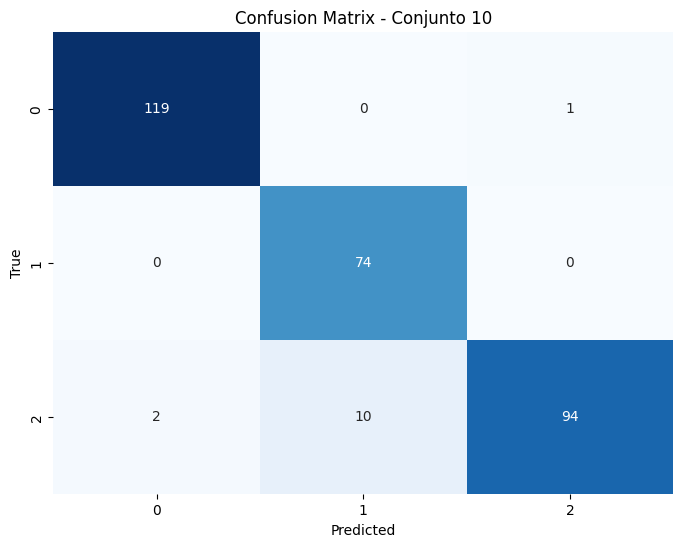

Acurácia no conjunto de teste: 85.33%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       120
           1       0.88      1.00      0.94        74
           2       0.99      0.89      0.94       106

    accuracy                           0.96       300
   macro avg       0.95      0.96      0.95       300
weighted avg       0.96      0.96      0.96       300


----------------------------------------------------------------



In [ ]:
# Convert predictions to labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
# Calculate the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Bom', 'Médio', 'Mal'], yticklabels=['Bom', 'Médio', 'Mal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - Conjunto {i + 1}')
plt.show()

print(f'Acurácia {accuracy * 100:.2f}%\n')

# Print classification report
classification_rep = classification_report(y_test_labels, y_pred_labels)
print(f'Relatório de Classificação:\n{classification_rep}')

print('\n----------------------------------------------------------------\n')